# TRATAMENTO EMPRESAS

In [4]:
from numpy import nan
import pandas as pd
data = pd.DataFrame({
    'empresa': ['ABC', 'BRF', 'TC'],
    'cvm': [789,989,1051],
    2000: [100,120,92],
    2005: [120,nan,nan],
    2010:[130,1_000,nan],
    2015:[230,1_800,nan],
    2020:[300,4_000,300],
    2023:[350,10_000,200]
})
data



,empresa,cvm,2000,2005,2010,2015,2020,2023
0,ABC,789,100,120.0,130.0,230.0,300,350
1,BRF,989,120,NaN,1000.0,1800.0,4000,10000
2,TC,1051,92,NaN,NaN,NaN,300,200


In [5]:
data = data.melt(id_vars = ["empresa", "cvm"], var_name = "ano", value_name = "faturamento")
data

,empresa,cvm,ano,faturamento
0,ABC,789,2000,100.0
1,BRF,989,2000,120.0
2,TC,1051,2000,92.0
3,ABC,789,2005,120.0
4,BRF,989,2005,NaN
5,TC,1051,2005,NaN
6,ABC,789,2010,130.0
7,BRF,989,2010,1000.0
8,TC,1051,2010,NaN
9,ABC,789,2015,230.0


In [6]:
new_data = (
    data.query("ano.isin([2000,2023])")
    .sort_values(["empresa", "ano"], ascending = [True, True])
    .assign(percentual = lambda x: x.groupby(by = "empresa")["faturamento"].pct_change()*100)
    )

new_data

,empresa,cvm,ano,faturamento,percentual
0,ABC,789,2000,100.0,NaN
15,ABC,789,2023,350.0,250.000000
1,BRF,989,2000,120.0,NaN
16,BRF,989,2023,10000.0,8233.333333
2,TC,1051,2000,92.0,NaN
17,TC,1051,2023,200.0,117.391304


In [20]:
# Utilizando a API do BCB para captação de dados sobre IPCA
from bcb import sgs
ipca = sgs.get({'IPCA' : 433}, start = "2000-01-01")
ipca = ipca.reset_index()
ipca["Date"] = ipca["Date"].astype(str).str.slice(0,4)
ipca.Date = ipca["Date"].astype(int)
ipca

,Date,IPCA
0,2000,0.62
1,2000,0.13
2,2000,0.22
3,2000,0.42
4,2000,0.01
...,...,...
279,2023,0.61
280,2023,0.23
281,2023,-0.08
282,2023,0.12


In [21]:
# Transformando a coluna que estava como índice 
# em coluna, para trabalhar com ela (Date) 
infla_anual = ipca.groupby("Date")["IPCA"].sum()
infla_anual = infla_anual.to_frame()
infla_anual = infla_anual.reset_index()
infla_anual

,Date,IPCA
0,2000,5.83
1,2001,7.42
2,2002,11.90
3,2003,8.95
4,2004,7.35
5,2005,5.55
6,2006,3.10
7,2007,4.37
8,2008,5.75
9,2009,4.23


In [22]:
# Juntando os dois DataFrames

data_frame = pd.merge(left = data, right = infla_anual, how = "left", left_on = "ano", right_on = "Date")
del data_frame["Date"]
data_frame = data_frame[["empresa", "ano", "cvm", "faturamento", "IPCA"]]
data_frame

,empresa,ano,cvm,faturamento,IPCA
0,ABC,2000,789,100.0,5.83
1,BRF,2000,989,120.0,5.83
2,TC,2000,1051,92.0,5.83
3,ABC,2005,789,120.0,5.55
4,BRF,2005,989,NaN,5.55
5,TC,2005,1051,NaN,5.55
6,ABC,2010,789,130.0,5.76
7,BRF,2010,989,1000.0,5.76
8,TC,2010,1051,NaN,5.76
9,ABC,2015,789,230.0,10.19


In [23]:
# Realizando agrupamento, para a análise da 
# variação do faturamento entre 2000 - 2023 (nominal e real)

novos_dados = (
    data_frame.query("ano.isin([2000, 2023])")
    .sort_values(by = ["empresa", "ano"])
    .assign(
        variacao = lambda x: x.groupby(by = "empresa")["faturamento"].pct_change() * 100,
        var_real = lambda x: x["variacao"] - sum(data_frame["IPCA"].unique())
    )
    .assign(
        variacao = lambda x: x["variacao"].round(),
        var_real = lambda x: x["var_real"].round()
    )
    .filter(["empresa", "ano", "faturamento", "variacao", "IPCA", "var_real"])
)

novos_dados = novos_dados.query("ano == 2023").filter(["empresa", "ano", "faturamento", "variacao", "var_real"])
novos_dados.columns = ["Empresa", "Ano", "Faturamento", "Variacao (%)", "Var_Real (% (-IPCA))"]
novos_dados.index = range(novos_dados.shape[0])
novos_dados

,Empresa,Ano,Faturamento,Variacao (%),Var_Real (% (-IPCA))
0,ABC,2023,350.0,250.0,215.0
1,BRF,2023,10000.0,8233.0,8198.0
2,TC,2023,200.0,117.0,82.0


# TRATAMENTO ESTADOS 

In [29]:
import pandas as pd

dtb = pd.read_excel(r"C:\Users\user\programming\projeto_tpad\dados\NEGÓCIOS\dtb_uf.xlsx")
pib = pd.read_excel(r"C:\Users\user\programming\projeto_tpad\dados\NEGÓCIOS\pib_2010a2018.xlsx")

In [30]:
dtb

,cod_uf,nome_uf,sigla_uf,cod_regiao,regiao
0,11,Rondônia,RO,1,Norte
1,12,Acre,AC,1,Norte
2,13,Amazonas,AM,1,Norte
3,14,Roraima,RR,1,Norte
4,15,Pará,PA,1,Norte
5,16,Amapá,AP,1,Norte
6,17,Tocantins,TO,1,Norte
7,21,Maranhão,MA,2,Nordeste
8,22,Piauí,PI,2,Nordeste
9,23,Ceará,CE,2,Nordeste


In [31]:
pib

,ano,cod_uf,pib
0,2010,11,23.90789
1,2010,12,8.34236
2,2010,13,60.87712
3,2010,14,6.63915
4,2010,15,82.68452
...,...,...,...
238,2018,43,457.29396
239,2018,50,106.96914
240,2018,51,137.44285
241,2018,52,195.68172


In [32]:
# Juntando os dois DataFrames

dados = pd.merge(left = dtb, right = pib, how = "left")

In [25]:
# AS 5 PIORES ECONOMIAS DO BRASIL EM 2018:

worst_pib = (
    dados.query("ano == 2018")[["pib", "nome_uf"]]
    .sort_values(by = "pib")
)
worst_pib.index = range(worst_pib.shape[0])
worst_pib.head(5)

,pib,nome_uf
0,13.36999,Roraima
1,15.33112,Acre
2,16.79521,Amapá
3,35.66618,Tocantins
4,42.01798,Sergipe


In [26]:
# PIORES ECONOMIAS DO NORDESTE EM 2018:
ne = (
    dados.query("regiao == 'Nordeste' and ano == 2018")[["nome_uf","pib"]]
    .sort_values(by = "pib")[0:5]
)
ne.index = range(ne.shape[0])
ne

,nome_uf,pib
0,Sergipe,42.01798
1,Piauí,50.37842
2,Alagoas,54.41305
3,Paraíba,64.37360
4,Rio Grande do Norte,66.96956


In [27]:
# OS 5 ESTADOS COM MAIOR AUMENTO DE PIB ENTRE 2010-2018
total = (
    dados.query("ano.isin([2010, 2018])")
    .sort_values(by = ["cod_uf", "pib"], ascending = [False, True])
    .assign(diferenca = lambda x: x.groupby("cod_uf")["pib"].pct_change() * 100).round(2)
    .filter(["cod_uf", "nome_uf", "regiao", "diferenca"])
)
total = total.sort_values(by = "diferenca", ascending= False)
total.index = range(total.shape[0])
total = total[0:27]
total.head(5)

,cod_uf,nome_uf,regiao,diferenca
0,51,Mato Grosso,Centro-Oeste,142.83
1,50,Mato Grosso do Sul,Centro-Oeste,126.29
2,22,Piauí,Nordeste,126.23
3,17,Tocantins,Norte,117.41
4,21,Maranhão,Nordeste,112.01


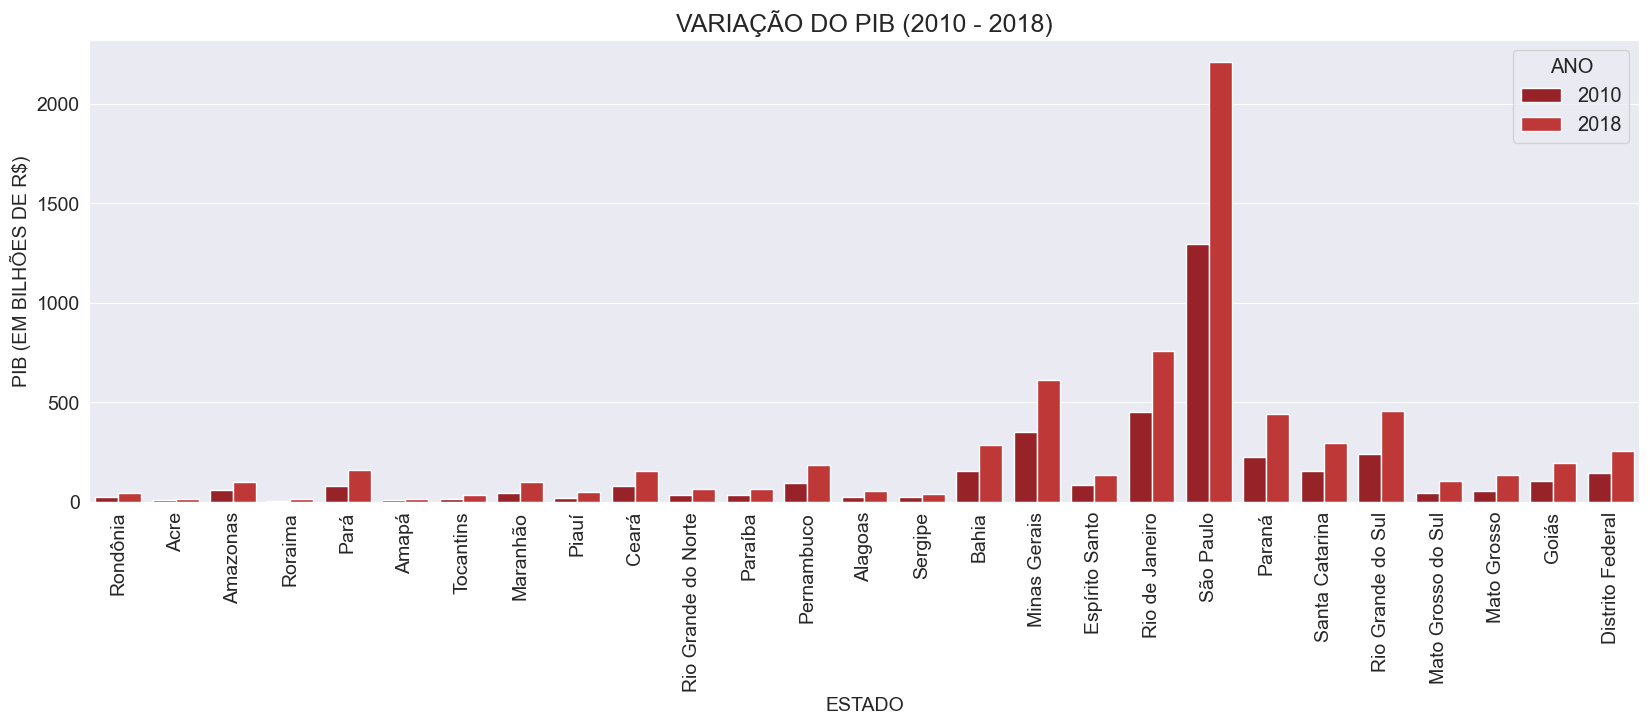

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

piby = dados.query("ano.isin([2010, 2018])")

plt.figure(figsize=(20, 6))

sns.set_palette("Reds_r")
sns.set_style("darkgrid")

ax = sns.barplot(y='pib', x='nome_uf', hue = "ano", data= piby, orient = "v")
ax.set_xlabel("ESTADO", fontsize = 14)
ax.set_ylabel("PIB (EM BILHÕES DE R$)", fontsize = 14)
ax.set_title("VARIAÇÃO DO PIB (2010 - 2018)", fontsize = 18)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 14)

plt.legend(title = "ANO", fontsize = "x-large", title_fontsize = "x-large")